# Titanic Fare Prediction

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [13]:

# 1) Load Dataset

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_ids = test["PassengerId"]

In [14]:
# Drop unnecessary columns
drop_cols = ["PassengerId","Name","Ticket","Cabin"]
train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

In [33]:

# 2) Handle missing values

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

In [25]:
# Fill numeric with median
for col in numeric_cols:
    train[col] = train[col].fillna(train[col].median())
    # Only fill in test set if the column exists in test
    if col in test.columns:
        test[col] = test[col].fillna(train[col].median())

In [17]:
# Fill categorical with mode
for col in categorical_cols:
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(train[col].mode()[0], inplace=True)


/tmp/ipython-input-276515201.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
/tmp/ipython-input-276515201.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [32]:
# 3) Features & Target
# ---------------------------
# Remove 'Survived' from features as it's not available in the test set for fare prediction.
X = train.drop(["Fare", "Survived"], axis=1)
y = train["Fare"]

In [19]:
# 4) Preprocessing

numeric_transformer = Pipeline([("scaler", StandardScaler())])
categorical_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))])
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

In [20]:
# 5) Train/Test Split
# ---------------------------
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# 6) Decision Tree Regressor

dt_pipeline = Pipeline([("pre", preprocessor), ("dt", DecisionTreeRegressor(random_state=42))])
dt_param_grid = {
    "dt__max_depth": [3,5,7,None],
    "dt__min_samples_split": [2,4,6],
    "dt__min_samples_leaf": [1,2,4]
}
dt_search = GridSearchCV(dt_pipeline, dt_param_grid, cv=4, scoring="neg_root_mean_squared_error", n_jobs=-1)
dt_search.fit(X_train, y_train)
dt_best = dt_search.best_estimator_
print("Decision Tree best params:", dt_search.best_params_)

Decision Tree best params: {'dt__max_depth': 3, 'dt__min_samples_leaf': 4, 'dt__min_samples_split': 2}


In [22]:
# 7) SVR

svr_pipeline = Pipeline([("pre", preprocessor), ("svr", SVR())])
svr_param_grid = {
    "svr__C": [0.1,1,10],
    "svr__gamma": ["scale","auto"],
    "svr__kernel": ["rbf","poly"],
    "svr__epsilon": [0.1,0.2]
}
svr_search = GridSearchCV(svr_pipeline, svr_param_grid, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1)
svr_search.fit(X_train, y_train)
svr_best = svr_search.best_estimator_
print("SVR best params:", svr_search.best_params_)

SVR best params: {'svr__C': 10, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'poly'}


In [27]:
# 8) Evaluation

def evaluate(model, X_val, y_val):
    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    # Calculate RMSE by taking the square root of MSE
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)
    return mae, rmse, r2, preds

dt_mae, dt_rmse, dt_r2, dt_preds = evaluate(dt_best, X_valid, y_valid)
svr_mae, svr_rmse, svr_r2, svr_preds = evaluate(svr_best, X_valid, y_valid)

print("\nDecision Tree -> MAE:", dt_mae, "RMSE:", dt_rmse, "R2:", dt_r2)
print("SVR           -> MAE:", svr_mae, "RMSE:", svr_rmse, "R2:", svr_r2)


Decision Tree -> MAE: 15.719900987513732 RMSE: 30.04728010900088 R2: 0.4165556671452353
SVR           -> MAE: 10.322690552064337 RMSE: 25.443272444036914 R2: 0.5816545679800107


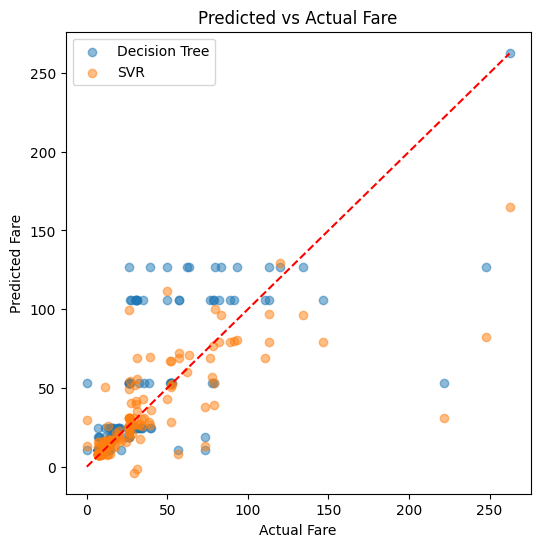

In [28]:

# 9) Predicted vs Actual Plot

plt.figure(figsize=(6,6))
plt.scatter(y_valid, dt_preds, alpha=0.5, label="Decision Tree")
plt.scatter(y_valid, svr_preds, alpha=0.5, label="SVR")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], ls="--", c="red")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.legend()
plt.title("Predicted vs Actual Fare")
plt.show()

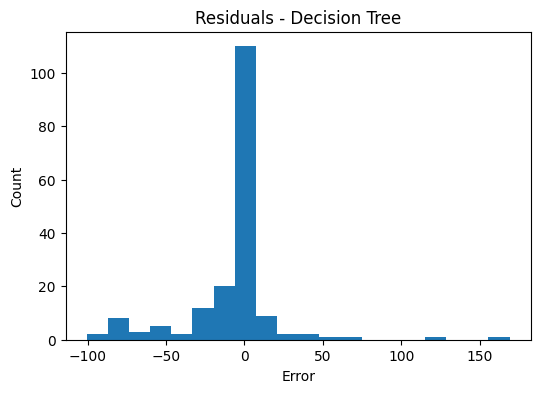

In [29]:
# ---------------------------
# 10) Residuals - Decision Tree
# ---------------------------
residuals_dt = y_valid - dt_preds
plt.figure(figsize=(6,4))
plt.hist(residuals_dt, bins=20)
plt.title("Residuals - Decision Tree")
plt.xlabel("Error")
plt.ylabel("Count")
plt.show()

In [35]:
# accuracy of the model DT
dt_mae, dt_rmse, dt_r2, dt_preds = evaluate(dt_best, X_valid, y_valid)
print("Decision Tree -> MAE:", dt_mae, "RMSE:", dt_rmse, "R2:", dt_r2)

Decision Tree -> MAE: 15.719900987513732 RMSE: 30.04728010900088 R2: 0.4165556671452353


In [37]:
#accuracy of the model SVR
svr_mae, svr_rmse, svr_r2, svr_preds = evaluate(svr_best, X_valid, y_valid)
print("SVR  -> MAE:", svr_mae, "RMSE:", svr_rmse, "R2:", svr_r2)

SVR  -> MAE: 10.322690552064337 RMSE: 25.443272444036914 R2: 0.5816545679800107
